## 7. Docking and Rerun OpenMM (In progress)

### 💡Results Preview (In progress)

<img src="./pics/ligand_pos1_loop_contact.png" width="400" />

- The ligand is docked to BfIMTD receptor and presents close contacts predicted in pymol with the loop and catalytic residues.

### 7.1 Docking
1. prepare ligand pdbqt file using open obabel
2. prepare receptor pdbqt file using mgltools
3. confirm docking box positions 
4. dock protein and ligand using Autodock Vina

### 7.2 MD using protein-ligand complex
5. rerun loop MD using OpenMM (IN PROGRESS)

--- - ---

In this notebook, I try dock the IG3 (Isomaltotriose, the particular product of target enzyme BfIMTD) to BfIMTD. There are several benefits after docking.
1. can directly view the spatial correlation between the loop region and the ligand.
2. explore practical position of the ligand in the catalytic tunnel.
3. find possible contacts between the ligand and the loop atoms.
4. predict potential interactions between the ligand and catalytic residues.
   
- After docking, it will be more direct to investigate the loop's function. The complex after docking can be a more useful input of OpenMM MD to simulate the protein's actual changes when encountering a ligand.

#### 7.1.1 prepare ligand pdbqt file using open babel
1. deploy open babel
2. download ligand file
- https://pubchem.ncbi.nlm.nih.gov/compound/Isomaltotriose
- download 3D Conformer SDF file
- saved in [data/ligand]
3. transfer .sdf file into .pdbqt file using commands, saved in [results/obabel]

In [ ]:
# install openbabel
conda install -c conda-forge openbabel

In [ ]:
# transfer .sdf into .pdb
obabel Isomaltotriose_Conformer3D_COMPOUND_CID_5460037.sdf -O IG3_ligand.pdb
# transfer .pdb into .pdbqt
obabel IG3_ligand.pdb -O IG3.pdb

#### 7.1.2 prepare receptor pdbqt file using mgltools

- don't use open babel to prepare protein pdbqt instead use autodocktools. However, my mac cannot deploy autodocktools.(I have tried but failed.)
  
##### 7.1.2.1 Deploy Linux virtual system on mac
- 1. install UTM
- 2. install ubuntu-18.04.6-desktop-amd64.iso
- 3. install mgltools on ubuntu 18
- 4. download mgltools_Linux-x86_64_1.5.7_Install
- 5. install mgltools in terminal
- 6. setup share folders to transfer target files 

In [ ]:
# linux terminal 

### deploy virtual linux and ubuntu system

#### install mgltools on virtual sys
cd ~/Download
chmod +x mgltools_Linux-x86_64_1.5.7_Install
./mgltools_Linux-x86_64_1.5.7_Install

##### 7.1.2.2 transfer receptor file into target .pdbqt
- use the command below
- receptor.pdbqt is saved in [results/mgltools]

In [ ]:
prepare_receptor4.py -r /home/yourname/Downloads/your_protein.pdb -o /home/yourname/Downloads/receptor.pdbqt

### 7.1.3. confirm docking box positions 
- use fpocket to prepare pockets parameters
- install fpocket in linux
- use pymol to find pocket box
   
1. I use pymol to visualize potential pockets from fpocket prediction and confirm the position of possible boxes.
- use the command below in pymol to draw possible box frames and axes in pymol

In [ ]:
# pymol 
@/full_path/draw_docking_box_in_pymol.pml # draw boxes
@/full_path/draw_axes_with_labels.pml     # draw axes                            

In [ ]:
#draw_docking_box_in_pymol.pml

# use target atoms to create a pocket box
# visualize the box in pymol

# === Step 1: set box center and size ===
center_x = -1.753999948501587
center_y = 6.751999855041504
center_z = -14.369999885559082

size_x = 20
size_y = 30
size_z = 18

# === Step 2: caliculate box boundary ===
x1 = center_x - size_x/2
x2 = center_x + size_x/2
y1 = center_y - size_y/2
y2 = center_y + size_y/2
z1 = center_z - size_z/2
z2 = center_z + size_z/2

# === Step 3: create 8 corner point ===
cmd.pseudoatom("p1", pos=[x1,y1,z1])
cmd.pseudoatom("p2", pos=[x2,y1,z1])
cmd.pseudoatom("p3", pos=[x2,y2,z1])
cmd.pseudoatom("p4", pos=[x1,y2,z1])
cmd.pseudoatom("p5", pos=[x1,y1,z2])
cmd.pseudoatom("p6", pos=[x2,y1,z2])
cmd.pseudoatom("p7", pos=[x2,y2,z2])
cmd.pseudoatom("p8", pos=[x1,y2,z2])

# === Step 4: connect the points to form lines ===
cmd.distance("line1", "p1", "p2")
cmd.distance("line2", "p2", "p3")
cmd.distance("line3", "p3", "p4")
cmd.distance("line4", "p4", "p1")

cmd.distance("line5", "p5", "p6")
cmd.distance("line6", "p6", "p7")
cmd.distance("line7", "p7", "p8")
cmd.distance("line8", "p8", "p5")

cmd.distance("line9",  "p1", "p5")
cmd.distance("line10", "p2", "p6")
cmd.distance("line11", "p3", "p7")
cmd.distance("line12", "p4", "p8")

# === Step 5: clear relunctant lines ===
cmd.hide("nonbonded", "p*")
cmd.set("dash_width", 2.0)
cmd.set("dash_color", "yellow")

In [4]:
# draw_axes_with_labels.pml

# show axes use the following scripts
# origin
pseudoatom origin, pos=[0,0,0]

# X axis（red）+ label
pseudoatom x_axis, pos=[5,0,0]
distance x_line, origin, x_axis
label x_axis, "X"
color red, x_line
set label_color, red, x_axis

# Y axis（green）+ label
pseudoatom y_axis, pos=[0,5,0]
distance y_line, origin, y_axis
label y_axis, "Y"
color green, y_line
set label_color, green, y_axis

# Z axis（blue）+ label
pseudoatom z_axis, pos=[0,0,5]
distance z_line, origin, z_axis
label z_axis, "Z"
color blue, z_line
set label_color, blue, z_axis

# clear atom balls
hide nonbonded, origin x_axis y_axis z_axis

# make lines thicker
set dash_width, 2.0

2. Use the following key atoms to get the margin of the box
   
| Atom number | position | command | belongs to which pocket | x | y | z |
|:----:|:----:|----:|----:|----:|----:|----:|
| atom0 |  center of the cata tunnel  |  print(cmd.get_atom_coords("atom_0"))  | 29 | -1.8890000581741333 | 4.473999977111816 | -14.840999603271484 |
| atom1 |  atom adjacent to loop |  print(cmd.get_atom_coords("atom_1")) | 28 | 0.2529999911785126 | 18.04400062561035 | -7.926000118255615 |
| atom3 |  atom at another side  |  print(cmd.get_atom_coords("atom_2")) | 17 | -2.2339999675750732 | -4.673999786376953 | -20.288000106811523 |


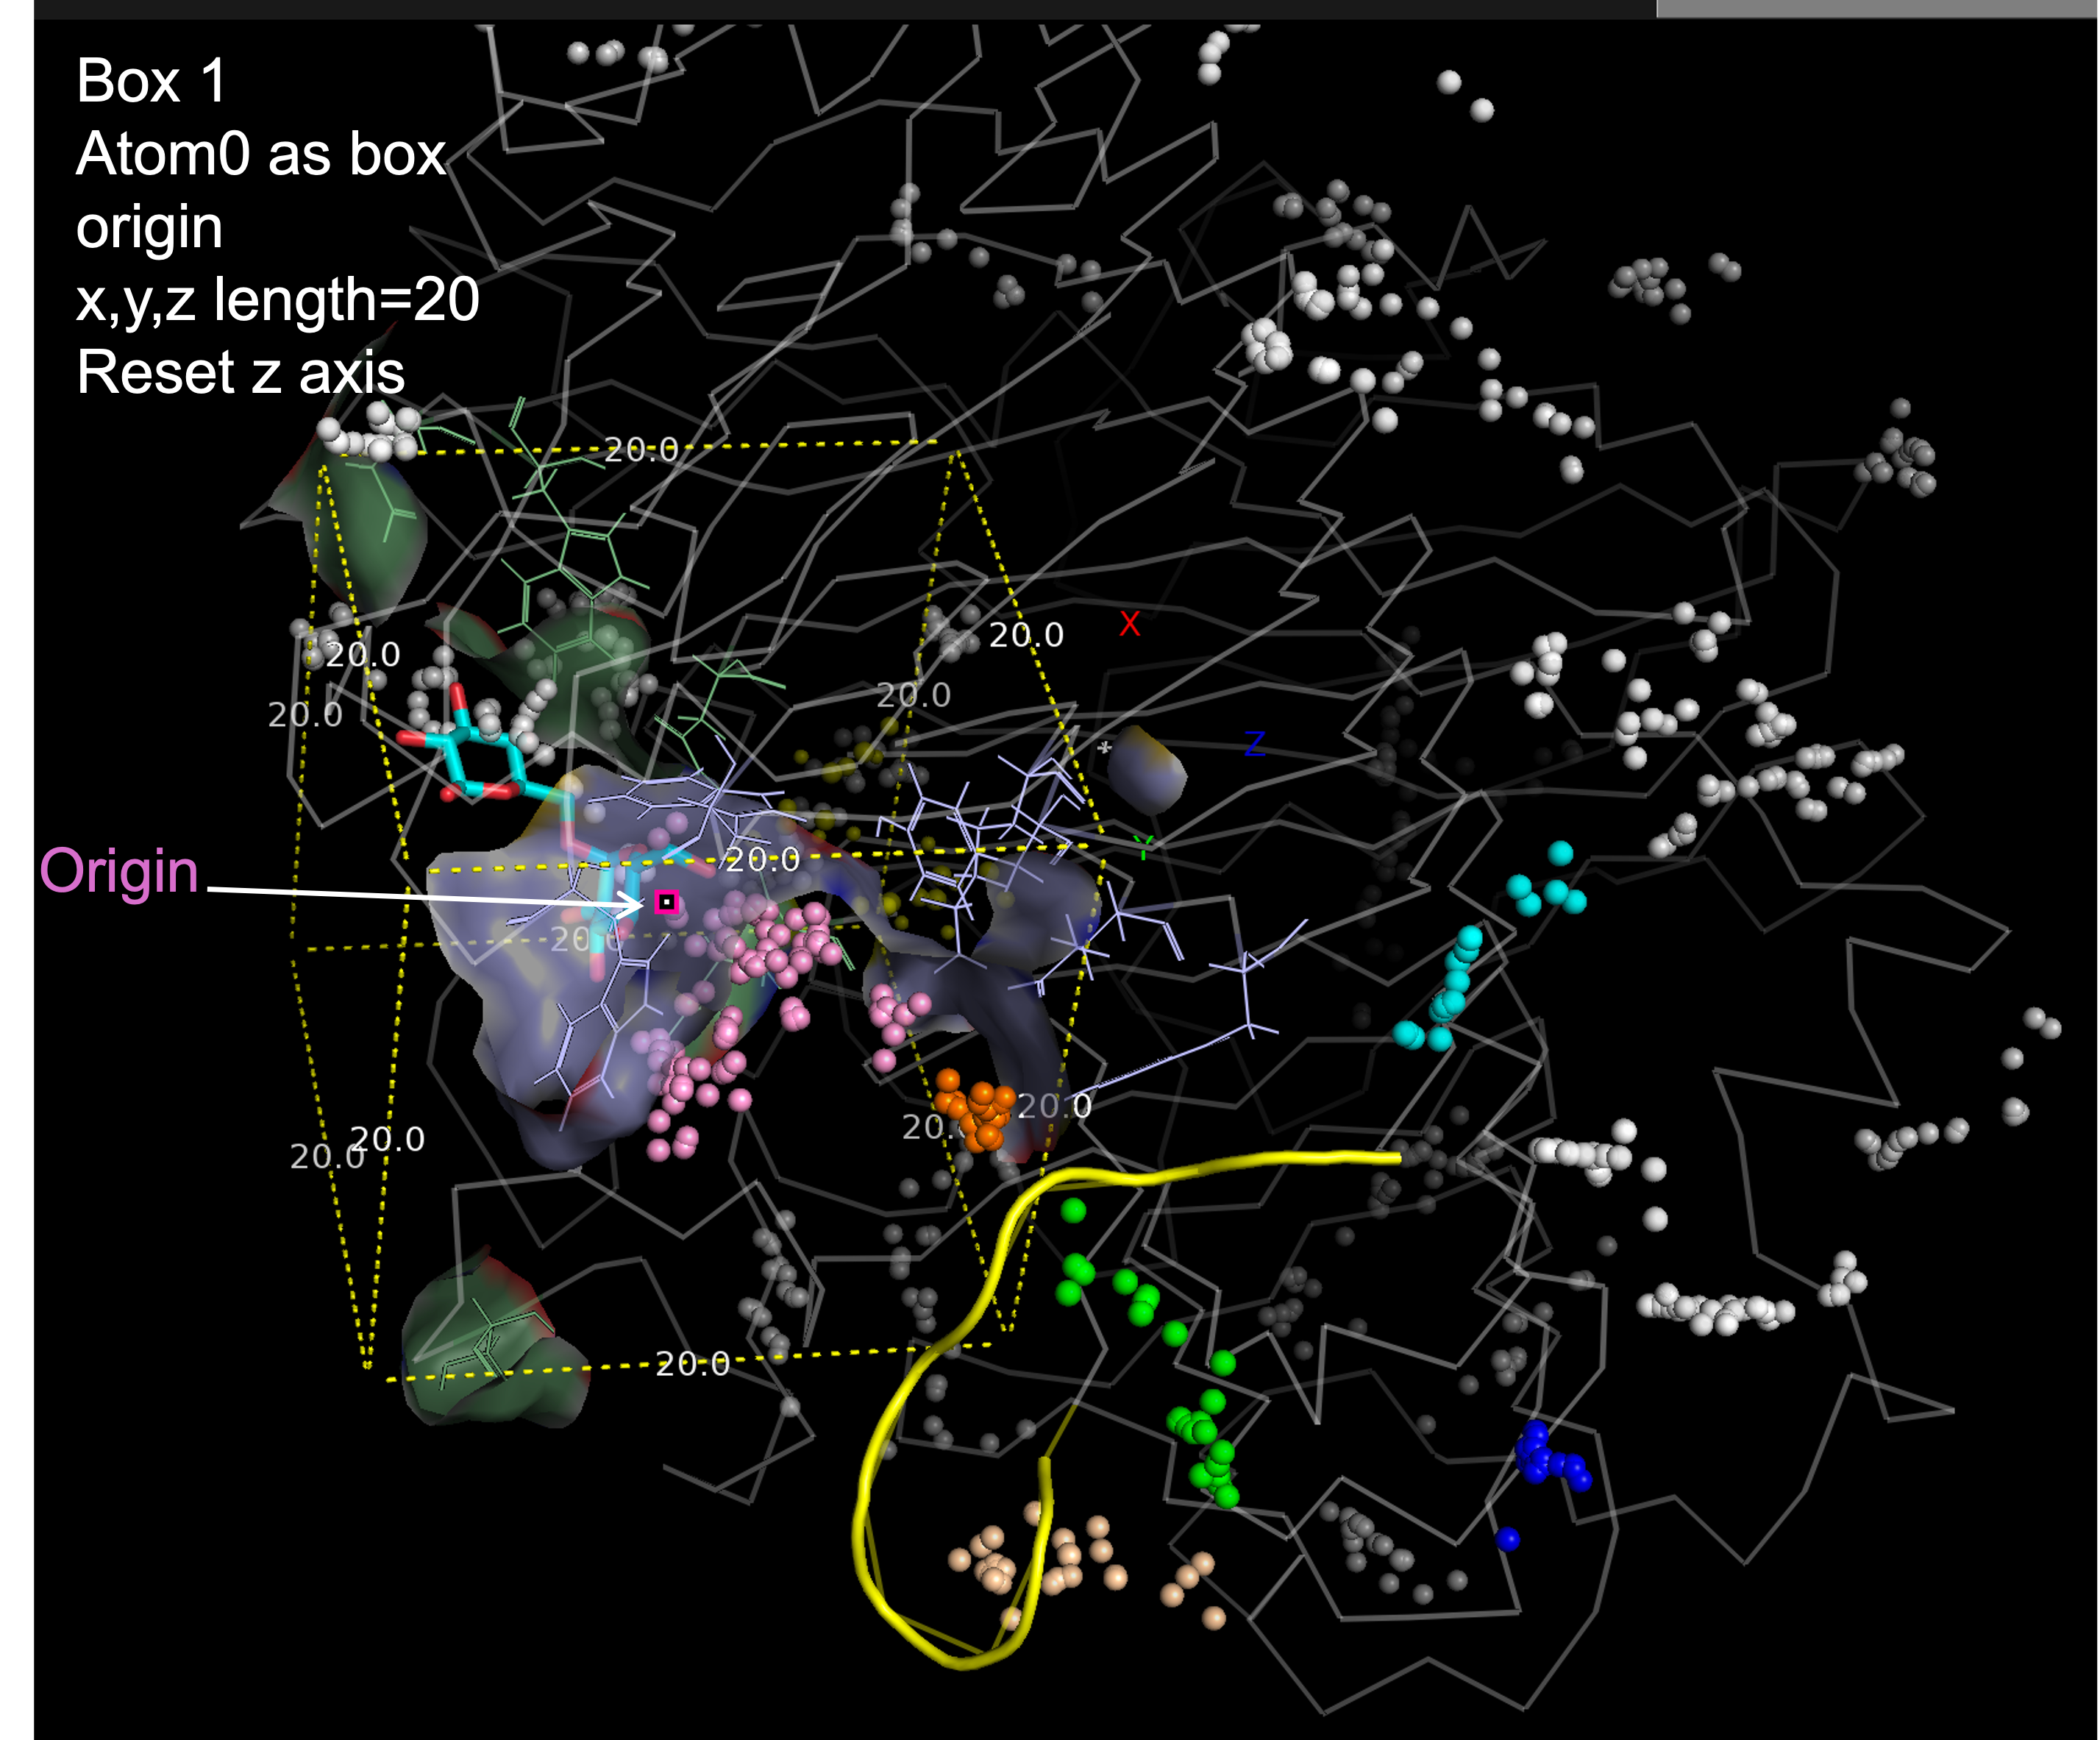

' Box 1 is the first try, the z axis length is a bit too long for the tunnel\nreduce z length and try second time '

In [11]:
from IPython.display import Image, display
display(Image(filename="./pics/pckt_box1.png", width=600))

""" Box 1 is the first try, the z axis length is a bit too long for the tunnel
reduce z length and try second time """

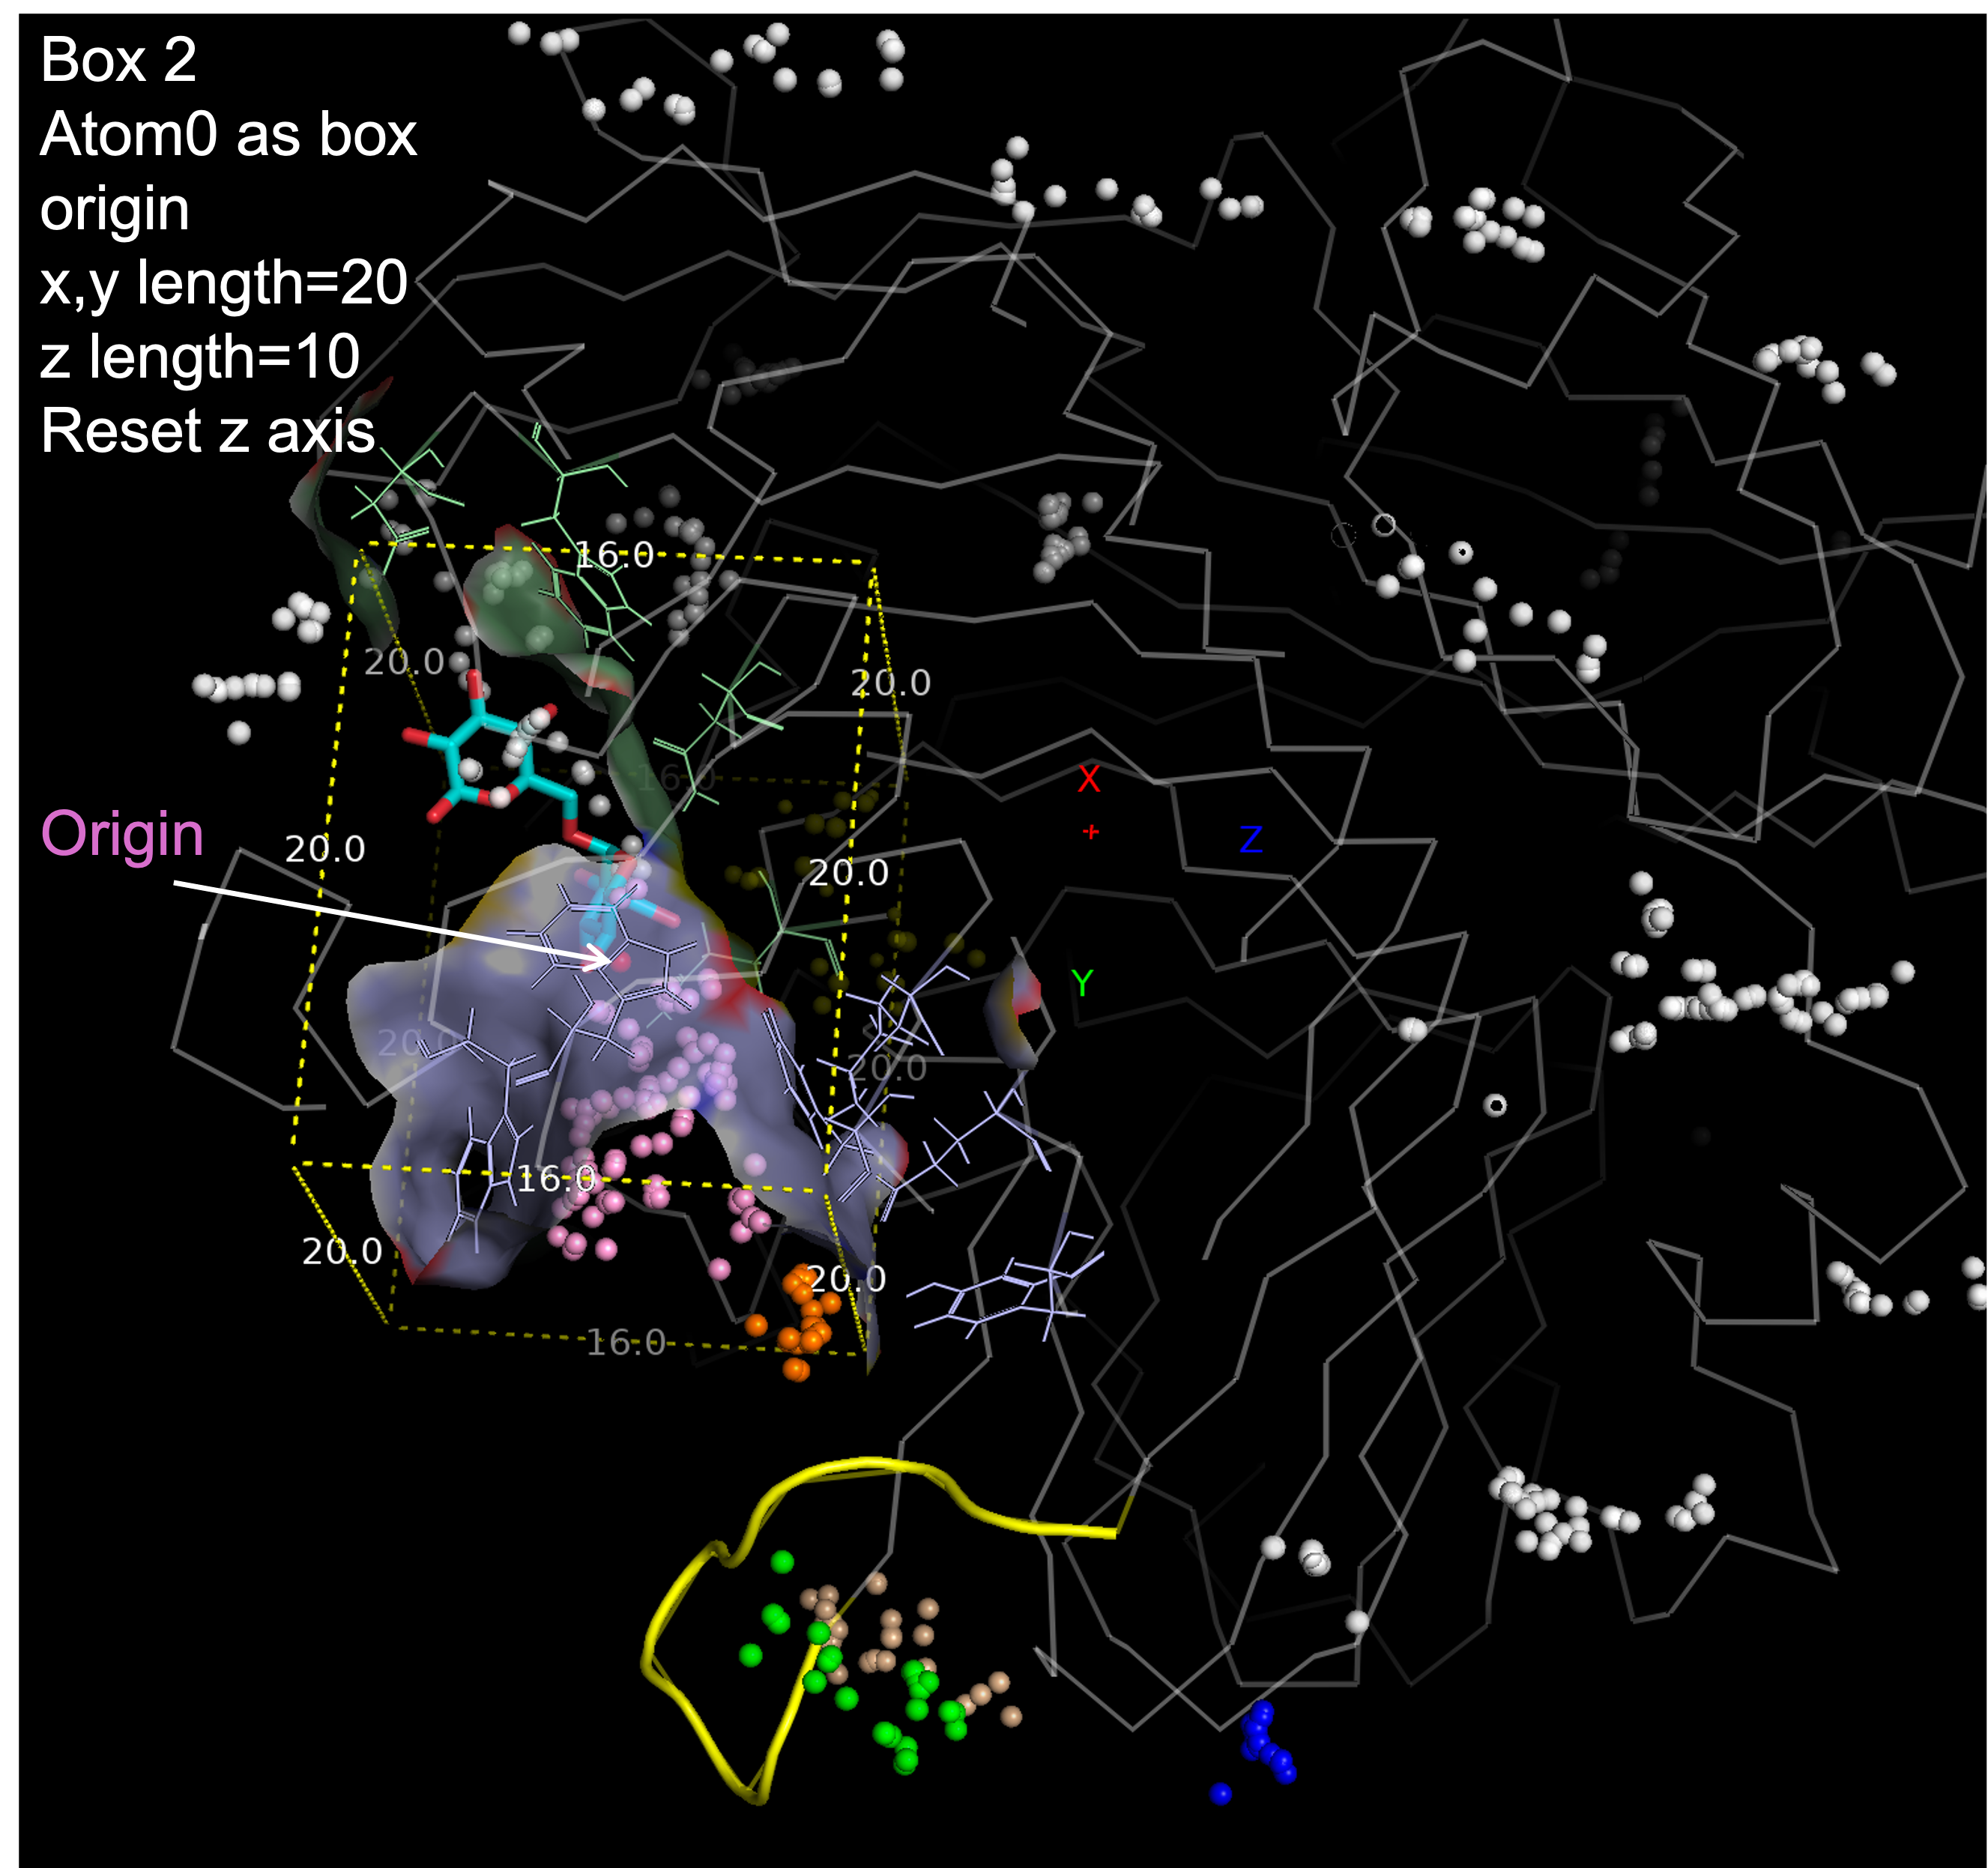

' - origin could be a little more closer to target loop(yellow)\n- length of y axis could be longer '

In [12]:
from IPython.display import Image, display
display(Image(filename="./pics/pckt_box2.png", width=600))

""" - origin could be a little more closer to target loop(yellow)
- length of y axis could be longer """

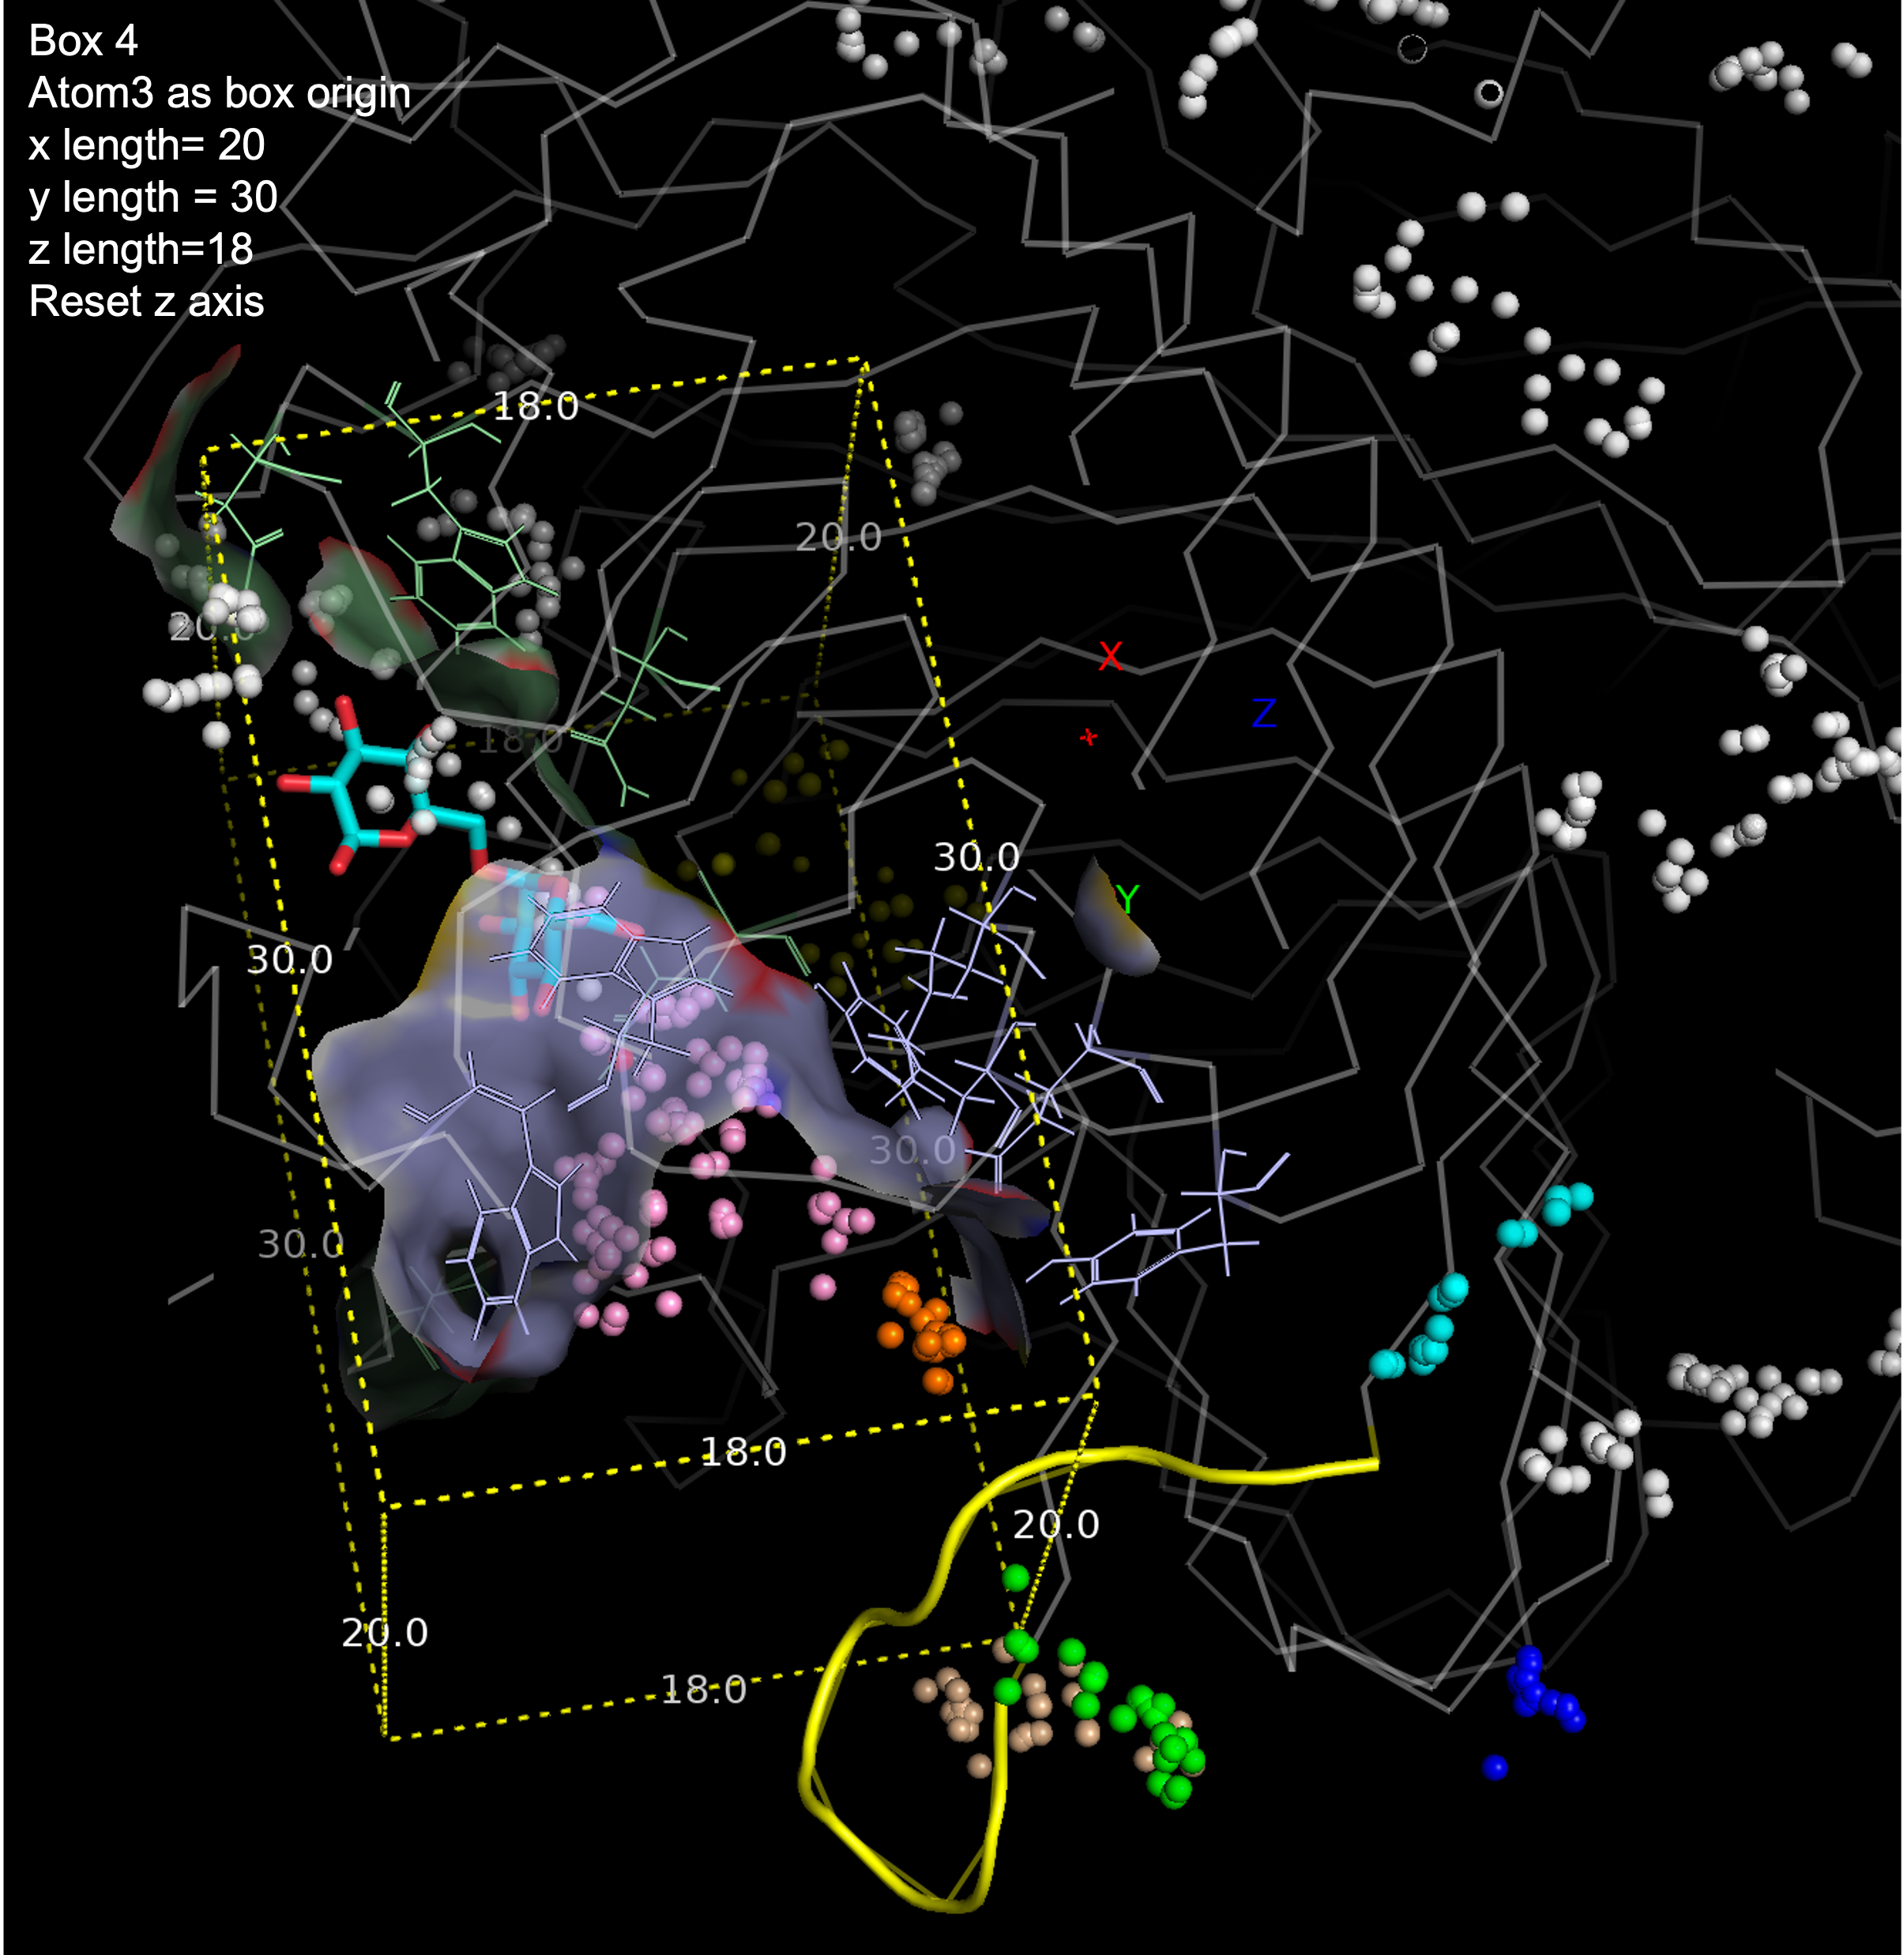

'this box can cover the space the ligand might move within the catalytic tunnel'

In [13]:
from IPython.display import Image, display
display(Image(filename="./pics/pckt_box4.png", width=600))

"""this box can cover the space the ligand might move within the catalytic tunnel"""

In [ ]:
# use these commands in pymol to remove boxes 
delete p*
delete line*

### 7.1.4. dock protein and ligand using Autodock Vina
#### 7.1.4.1 deploy AutoDock Vina
- install Autodock Vina on mac use the following commands

In [ ]:
# bash
wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.7/vina_1.2.7_mac_aarch64
mv vina_1.2.7_mac_aarch64 vina # rename
chmod +x vina

./vina
ls -l vina
###➡️ -rwxr-xr-x  1 yiziling  staff  1171704  3  9 08:20 vina
# Install vina successfully.

In [ ]:
# bash 
sudo nano ~/.zshrc # add vina to PATH
export PATH="/Volumes/APFS/tools/vina:$PATH" # add this command to the file, control+O save the file and enter, then control+X exit the editing page.

source ~/.zshrc # make it avaliable
vina --help # use this command to get help

Or download manually if the internet is unstable
- download autodock vina zip from https://github.com/ccsb-scripps/AutoDock-Vina/releases/ 
- vina_1.2.7_mac_x86_64.zip is saved in tools/vina

#### 7.1.4.2 deploy AutoDock Vina
- use commands to dock target protein and ligand together.
- ✔️ ligand.pdbqt prepared.
- ✔️ protein.pdbqt prepared.
- ✔️ box parameters (see above box 4, atom 3 as the origin) ready.

In [ ]:
# template below
vina \
  --receptor receptor.pdbqt \   
  --ligand ligand.pdbqt \       
  --center_x -1.753999948501587 --center_y 6.751999855041504 --center_z -14.369999885559082 \  
  --size_x 20 --size_y 30 --size_z 18 \     
  --out out.pdbqt \           

In [ ]:
# run the following command in bash
cd ../results/vina
vina \
--receptor ../mgltools/imtd.pdbqt \
--ligand ../obabel/IG3.pdbqt 
--center_x -1.753999948501587 --center_y 6.751999855041504 --center_z -14.369999885559082 \
--size_x 20 --size_y 30 --size_z 18 \
--out imtd_ig3_box4.pdbqt \

- output file imtd_ig3_box4.pdbqt saved in [results/vina]

#### 7.1.4.3 view the composite and find contacts
1. Visulialize the composite in pymol
- use the following commands

2. predict interactions
- hydrogen bonds and other contacts 

In [ ]:
# pymol
# load receptor and ligand together in pymol
load protein.pdb
load imtd_ig3_box4.pdbqt, ig3

# predict possible contacts between loop and ligand
dist hbonds-4, loop_atoms, ligand_atoms, 4, 60
dist cata-hbonds-3.5, catalytic_residues, ligand_atoms, 3.5, 120

##### - *ligand position 1 and 3 and 9 show predicted interactions with loop residues*

In [21]:
# From the side of loop, possible contacts equal or less than 4
from IPython.display import HTML

HTML('''
<div style="display: flex; gap: 20px;">
  <img src="./pics/ligand_pos1_loop_contact.png" width="500">
  <img src="./pics/ligand_pos3_loop_contact.png" width="500">
  <img src="./pics/ligand_pos9_loop_contact.png" width="500">
</div>
''')

##### - *ligand position 1-9 all show predicted interactions with catalytic residues, 1, 2, 5, 9 are shown below.*

In [24]:
## predict possible contacts between loop and catalytic residues
HTML('''
<div style="display: flex; gap: 20px;">
  <img src="./pics/cata_pos1_contact.png" width="500">
  <img src="./pics/cata_pos2_contact.png" width="500">
</div>
''')

In [25]:
HTML('''
<div style="display: flex; gap: 20px;">
  <img src="./pics/cata_pos5_contact.png" width="500">
  <img src="./pics/cata_pos9_contact.png" width="500">
</div>
''')

In [ ]:
# use this line to split conformations
split_states ligand_docked # later argu use your specified ligand name when first introduce to pymol

### 7.2 MD using protein-ligand complex

In [ ]:
# in progress

### Reference:
1. McDonald IK, Thornton JM. Satisfying hydrogen bonding potential in proteins. J Mol Biol. 1994 May 20;238(5):777-93. doi: 10.1006/jmbi.1994.1334. PMID: 8182748.

### reference
J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, J. Comp. Chem. (2010)                         #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see https://github.com/ccsb-scripps/AutoDock-Vina for  #
# more information. 